# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-01-03.ipynb)

## Section 01: Introduction to Diffusion Models and Stable Diffusion

最先端の画像生成 AI である拡散モデル (diffusion model) と、その発展に大きく貢献している貢献している `Stable Diffusion` について導入します。

### Lecture 03: Play with Stable Diffusion

huggingface 社が作成している `diffusers` ライブラリを使用して Stable Diffusion を実際に動かしてみましょう。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度 `GPU 使用設定` のスライド説明等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Mon Aug 21 06:33:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ
- [xformers](https://github.com/facebookresearch/xformers): accelerate と同様に、Transformer モデルをより効率的に扱い高速な画像生成をサポートするライブラリ


In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00


## Stable Diffusion を扱うパイプラインを構築

今回使用する diffusers に用意されている`StableDiffusionPipeline` は数行のコードでテキストから画像を生成することができるパイプラインです。以下コードを実行することでパイプラインは学習済みのモデルをダウンロードします。5 GB ほど huggingface のサーバからデータがダウンロードされるので少し待ちます。

今回は stable diffusion モデルでよく利用されている `runwayml/stable-diffusion-v1-5` を指定していますが、他にも様々な選択肢があります:
  - [stabilityai/stable-diffusion-2](https://huggingface.co/stabilityai/stable-diffusion-2): Stable Diffusion の v2 系
  - [hakurei/waifu-diffusion](https://huggingface.co/hakurei/waifu-diffusion): アニメ画像生成に特化
  - [nitrosocke/Nitro-Diffusion](https://huggingface.co/nitrosocke/Nitro-Diffusion): 複数の画風で画像生成可能

ここでは `model_id` に `runwayml/stable-diffusion-v1-5` を指定しているのに加えて、特定の `revision` や `torch_dtype` を `from_pretrained` メソッドに渡しています。

無料で GPU が使用できる Colab で Stable Diffusion ベースのモデルを実行できるようにするため、半精度 float16 で学習済みモデルを読み込むように `torch_dtype=torch.float16` を指定します。

可能な限り高い精度で画像生成を行いたい場合は、GPU のメモリ使用量が増えてしまいますが `torch_dtype=torch.float16` を指定しないで実行してください。

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


次に、実行したパイプライン `pipe` を GPU へ移動させて、生成速度を高速化します。

In [ ]:
pipe = pipe.to("cuda")

これでテキストから画像を生成する準備が整いました。
プロンプトと呼ばれるテキストを与えて画像を生成してもらいます。
ここで生成される画像は 512 x 512 の解像度を持ちます。

  0%|          | 0/50 [00:00<?, ?it/s]

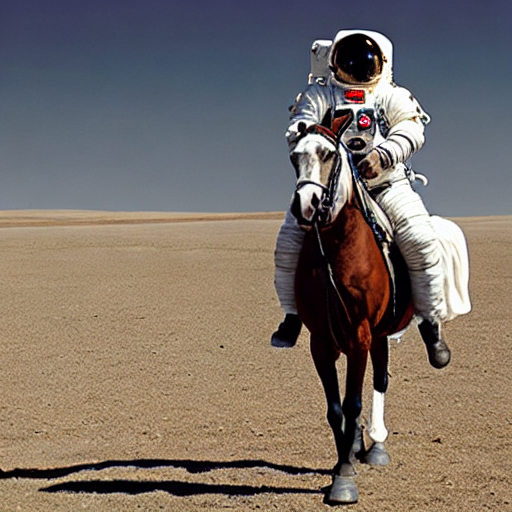

In [ ]:
# 宇宙飛行士が馬に乗っている写真
text = "a photograph of an astronaut riding a horse"
image = pipe(prompt=text).images[0]  # ここで image は [PIL](https://pillow.readthedocs.io/en/stable/) 形式です

# 画像を表示します
image

上記のセルを複数回実行すると、毎回異なる画像を得ることができます。
同様の出力（= 決定論的な出力）が欲しい場合は、パイプラインにランダムなシードを渡すことができます。
同じシード値を渡すことで同じ生成画像を得ることができます。

  0%|          | 0/50 [00:00<?, ?it/s]

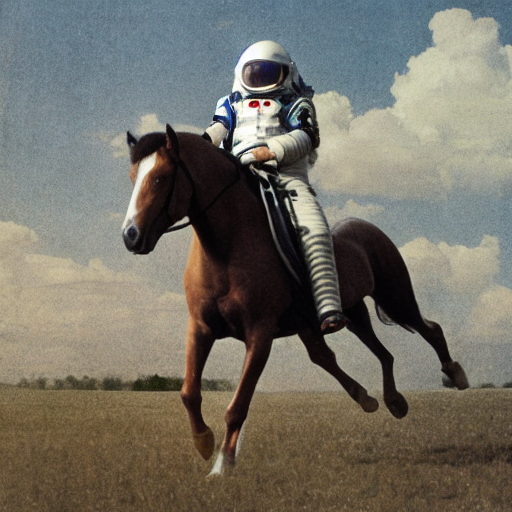

In [ ]:
import torch

# シード値を生成する generator を定義し、シード値を manual_seed で設定
generator = torch.Generator("cuda").manual_seed(19950815)
# pipe の引数である generator に上記のシード値を渡して画像を生成
image = pipe(prompt=text, generator=generator).images[0]

image

パイプラインにある `num_inference_steps` 引数で画像生成時のステップ数を変更することができます。
一般的に、より多くのステップ数を指定することでより良い結果を得ることができます。
最新のモデルの一つである Stable Diffusion は比較的少ないステップ数で高品質な画像を生成するので、デフォルト値である 50 を使用することが推奨されています。
より早く生成結果を得たい場合は、より少ないステップ数を使用します。

以下では前と同じシード値を使用していますが、ステップ数は少なくなっています。
馬の頭やヘルメットなどのパーツの細い部分の品質が多少劣ることに注意してみてください。

  0%|          | 0/15 [00:00<?, ?it/s]

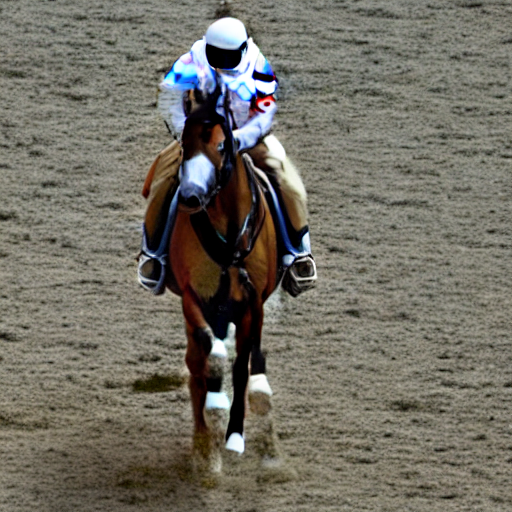

In [ ]:
import torch

# generator でシード値を取得
generator = torch.Generator("cuda").manual_seed(19950815)
# 取得したシード値で固定しつつ、num_inference_steps を 15 に設定 (デフォルトは 50)
image = pipe(prompt=text, generator=generator, num_inference_steps=15).images[0]

image

同じプロンプトに対して複数の画像を生成するには、パイプラインの `num_images_per_prompt` に生成したい画像数を指定します。

まず、生成画像を格子状に表示する関数を定義します。
以下のセルを実行するだけで上記を達成する `image_grid` 関数ができあがります。

In [ ]:
from PIL import Image
from PIL.Image import Image as PilImage
from typing import List

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols # 入力される画像数が行 x 列数と同じか確認

    # 行 x 列数のサイズにあったキャンバスを作成
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    # 作成したキャンバスに生成画像を貼り付けていく
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))

    # キャンバスを返却
    return grid

これで指定した数だけパイプラインで画像を生成し、格子状に画像を並べて表示することができるようになりました。

In [ ]:
text = "a photograph of an astronaut riding a horse"

num_rows = 4 # 行数を指定
num_cols = 3 # 列数を指定
num_images = num_rows * num_cols # 行数 x 列数が生成画像数に

output = pipe(prompt=text, num_images_per_prompt=num_images)

# image_grid 関数を使って生成画像群をグリッド上に並べて表示
grid = image_grid(output.images, rows=num_rows, cols=num_cols)
grid

Output hidden; open in https://colab.research.google.com to view.

## Stable Diffusion v1 を動かして画像生成してみる

以下に入力したプロンプトを元に生成された画像をいくつか例示します。

  0%|          | 0/50 [00:00<?, ?it/s]

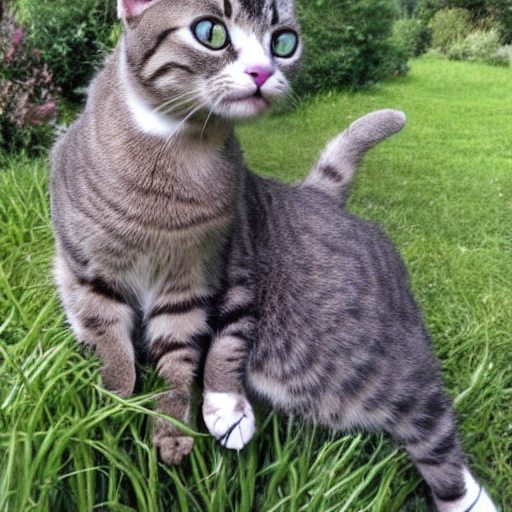

In [ ]:
import torch

# 吾輩は猫である。名前はまだ無い。（夏目漱石「吾輩は猫である」冒頭より）
text = "I am a cat. As yet I have no name."

# シード値を固定して画像を生成
generator = torch.Generator("cuda").manual_seed(19950815)
image = pipe(prompt=text, generator=generator).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

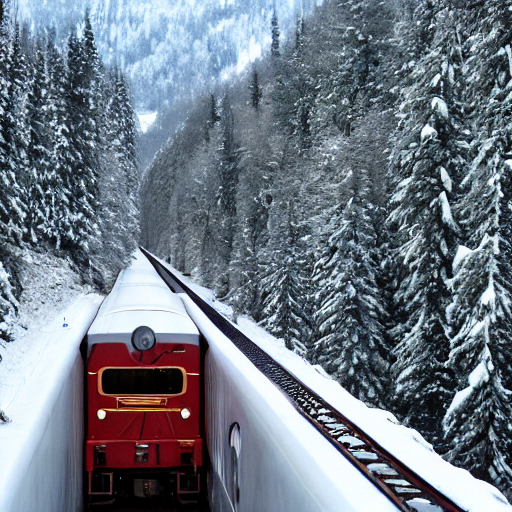

In [ ]:
import torch

# 国境の長いトンネルを抜けると雪国であった。（川端康成「雪国」冒頭より）
text = "The train came out of the long tunnel into the snow country."

# シード値を固定して画像を生成
generator = torch.Generator("cuda").manual_seed(19950815)
image = pipe(prompt=text, generator=generator).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

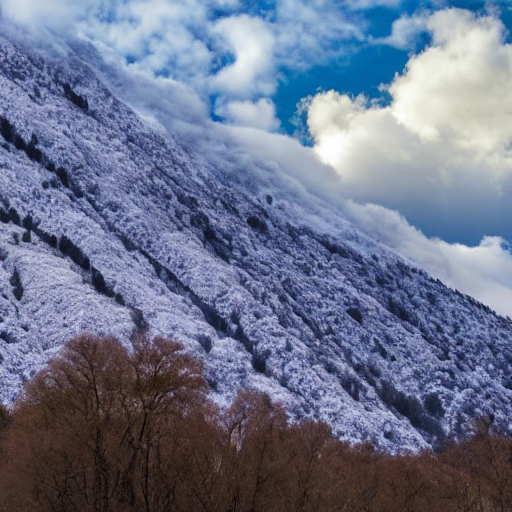

In [ ]:
import torch

# 春はあけぼの、ようよう白く成りゆく山際、少し明かりて、紫だちたる雲の細くたなびきたる。
# （清少納言「枕草子」冒頭より）
text = "In the dawn of spring, the mountains are turning white, \
        and the purple clouds are trailing thinly with a little light"

generator = torch.Generator("cuda").manual_seed(19950815)
image = pipe(prompt=text, generator=generator).images[0]

image

無料版の Colab を使用している場合、システムのメモリに一定の制限があります。以降、新たにパイプライン等を読み込んだりする関係上、これまで使用した変数を明示的に削除することでメモリを解放します。

In [ ]:
import gc

del pipe; del generator; del output; del image; del grid
gc.collect()

556

## Stable Diffusion v2 を動かして画像生成してみる

上記で使用した `runwayml/stable-diffusion-v1-5` はバージョン 1.5 の Stable Diffusion でした。このセクションではバージョンアップして 2 系になった Stable Diffusion で画像を生成してみます。

Stable Diffusion における v1 系と v2 系に大きな違いは (1) プロンプトテキストを扱うコンポーネントが変更されている点、(2) negative prompt と呼ばれる、画像生成に反映してもらいたくない条件を入力可能になった点、(3) 有名人の顔画像生成性能が向上した点、(4) 芸術性の高い画像を生成可能にした点、(5) 入力されるプロンプトテキストとの一貫性、(6) 根本的な機能改善（深さを捉えることが可能・より高い解像度の画像を生成可能）といった多数の技術的向上があります。

- 参考: [Stable Diffusion 1 vs 2 - What you need to know](https://www.assemblyai.com/blog/stable-diffusion-1-vs-2-what-you-need-to-know/)

以下で Stable Diffusion v2 を実際に動かしてみます。

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

model_id = "stabilityai/stable-diffusion-2"

scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Stable Diffusion v2 ではより高解像度な画像を生成可能です。高解像度画像を生成する場合より多くの GPU メモリが必要になりますが、Colab で使用できる GPU メモリには限りがあります。
ここでは先にインストールした `xformers` によるパイプラインの最適化を行うことで、使用する GPU メモリを大幅に削減します。

In [ ]:
pipe.enable_attention_slicing()

これで準備は整いました。プロンプトテキストを与えて画像を生成してもらいます。
従来の Stable Diffusion v1 系は 512 x 512 の解像度で画像を生成しましたが、今回 Stable Diffusion v2 では 768 x 768 の解像度で画像を生成させてみます。

  0%|          | 0/50 [00:00<?, ?it/s]

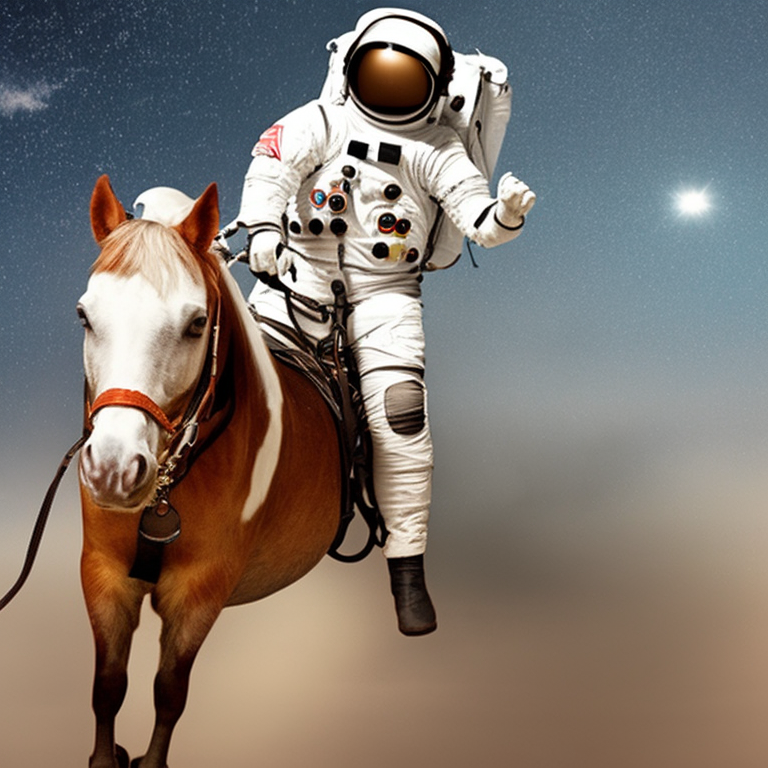

In [ ]:
text = "a photograph of an astronaut riding a horse"

# ここで image は [PIL](https://pillow.readthedocs.io/en/stable/) 形式です
image = pipe(prompt=text, height=768, width=768).images[0]

# 画像を表示します
image

以下に入力したプロンプト生成された画像をいくつか例示します。

  0%|          | 0/50 [00:00<?, ?it/s]

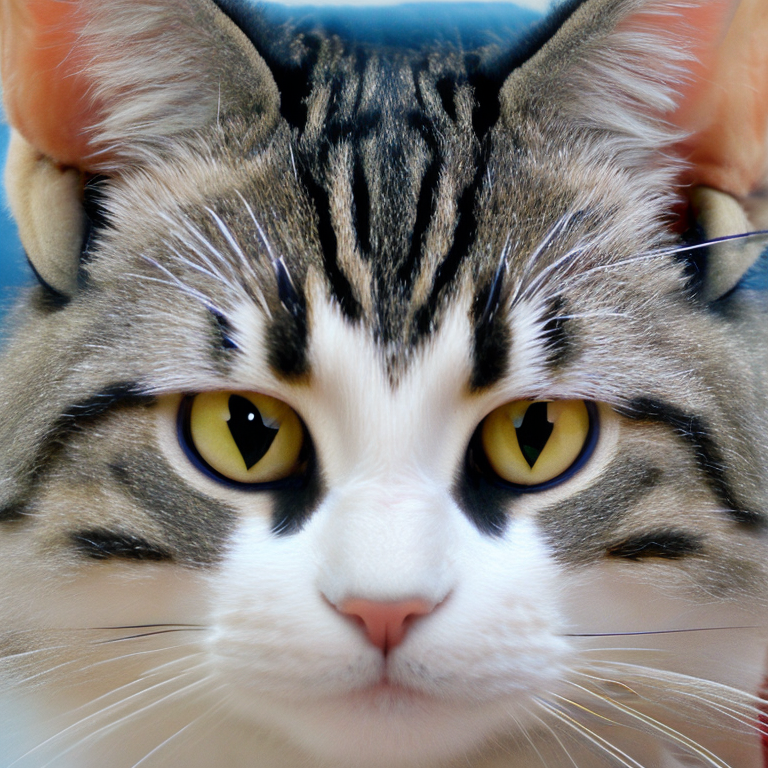

In [ ]:
import torch

# 吾輩は猫である。名前はまだ無い。
text = "I am a cat. As yet I have no name."

generator = torch.Generator("cuda").manual_seed(19950815)
image = pipe(prompt=text, generator=generator, height=768, width=768).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

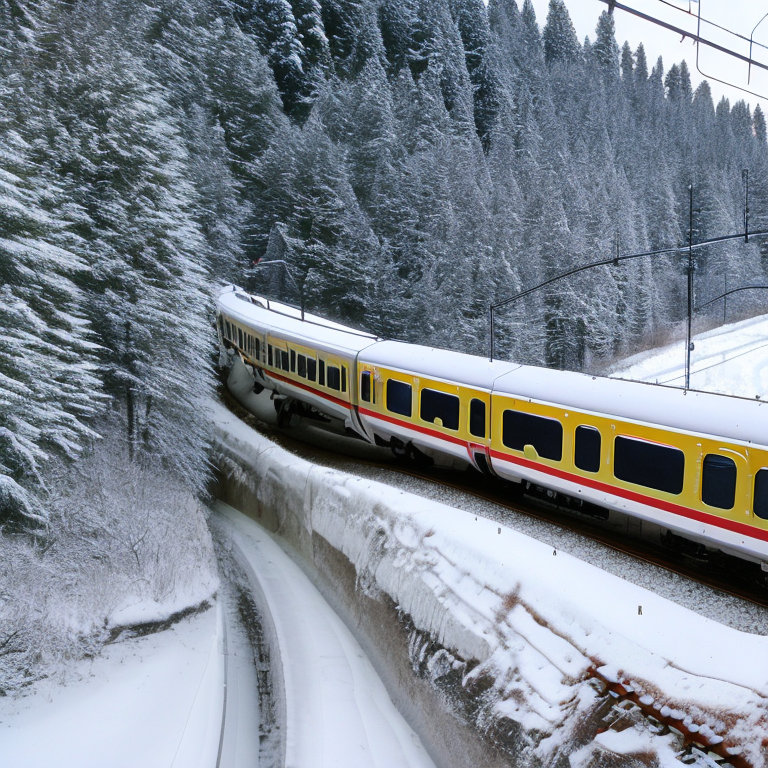

In [ ]:
import torch

# 国境の長いトンネルを抜けると雪国であった。
text = "The train came out of the long tunnel into the snow country."

generator = torch.Generator("cuda").manual_seed(19950815)
image = pipe(prompt=text, generator=generator, height=768, width=768).images[0]

image

  0%|          | 0/50 [00:00<?, ?it/s]

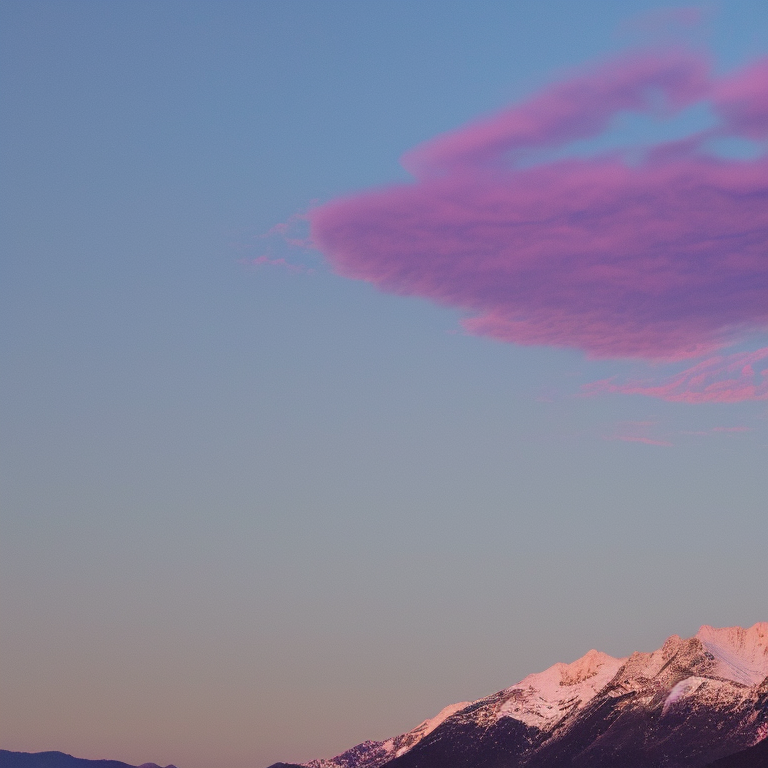

In [ ]:
import torch

# 春はあけぼの、ようよう白く成りゆく山際、少し明かりて、紫だちたる雲の細くたなびきたる。
text = "In the dawn of spring, the mountains are turning white, \
        and the purple clouds are trailing thinly with a little light"

generator = torch.Generator("cuda").manual_seed(19950815)
image = pipe(prompt=text, generator=generator, height=768, width=768).images[0]

image

先程と同様に、新たにパイプライン等を読み込んだりする関係上、これまで使用した変数を明示的に削除することでメモリを解放します。

In [ ]:
import gc

del pipe; del generator; del image
gc.collect()

40

## waifu-diffusion を動かして画像生成してみる

[waifu-diffusion](https://huggingface.co/hakurei/waifu-diffusion) は Stable Diffusion ベースのモデルをアニメ画像で fine-tuning した拡散モデルです。アニメキャラクターのような画風の画像を生成するのを得意としています。以下で waifu-diffusion を実際に動かしてみます。

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "hakurei/waifu-diffusion"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


これで準備は整いました。プロンプトテキストを与えて画像を生成してもらいます。

In [ ]:
text = "1girl, aqua eyes, baseball cap, blonde hair, \
        closed mouth, earrings, green background, hat, \
        hoop earrings, jewelry, looking at viewer, shirt, \
        short hair, simple background, solo, upper body, yellow shirt"

num_rows = 4
num_cols = 3
num_images = num_rows * num_cols

generator = torch.Generator("cuda").manual_seed(19950815)

output = pipe(prompt=text, generator=generator, num_images_per_prompt=num_images)

grid = image_grid(output.images, rows=num_rows, cols=num_cols)
grid

Output hidden; open in https://colab.research.google.com to view.

先程と同様に、新たにパイプライン等を読み込んだりする関係上、これまで使用した変数を明示的に削除することでメモリを解放します。

In [ ]:
import gc

del pipe; del output; del grid
gc.collect()

502

## nitro-diffusion を動かして画像生成してみる

[nitro-diffusion](https://huggingface.co/nitrosocke/Nitro-Diffusion) は Stable Diffusion ベースのモデルをゼロから訓練した複数の画風スタイルを生成可能な拡散モデルです。
3 つの画風がそれぞれ独立するよう同時に訓練されています。この訓練方法によってプロンプトに指定したキーワードを元に高品質な画像生成が可能になっています。3 つの画風はそれぞれ `archer` スタイル、、`arcane` スタイル、、`disney` スタイルに対応しており、これらのキーワードを入力することでキーワードを考慮した画風で画像生成ができます。複数のスタイルトークンを使って画風を混ぜ合わせた画像を生成できます。

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "nitrosocke/nitro-diffusion"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


これで準備は整いました。プロンプトテキストを与えて画像を生成してもらいます。

In [ ]:
text = "archer arcane style magical princess with golden hair"

num_rows = 4
num_cols = 3
num_images = num_rows * num_cols

generator = torch.Generator("cuda").manual_seed(19950815)

output = pipe(prompt=text, generator=generator, num_images_per_prompt=num_images)

grid = image_grid(output.images, rows=num_rows, cols=num_cols)
grid

Output hidden; open in https://colab.research.google.com to view.

### NSFW (not safe for work) 画像生成防止機構について

上記の画像生成結果の一部は `Potential NSFW content was detected in one or more images. A black image will be returned instead.` と表示されて真っ黒な画像が生成されています。NSFW とは not safe for work の略で、「職場での閲覧は危険」という意味です。Stable Diffusion Pipeline 内に追加されている NSFW フィルターによって、生成画像が性的または暴力的であると判断された場合にフィルタリングされます。

フィルタリング結果は必ずしも NSFW な生成画像を適切にフィルタリングしていないかもしれません。画像生成 AI には不適切な画像の生成をどの用に防止していくかも重要な議論点となっています。

## まとめ

近年の注目されているテキストから画像を生成可能な拡散モデルを複数実行していただきました。
上記以外にもさまざまな事前学習済みモデルが存在します。[huggingface models](https://huggingface.co/models) にて検索することができるので、生成してみたい画風を学習したモデル等見つけて実行してみてください。